Load the training data.

In [1]:
import utils
import numpy as np
import matplotlib.pyplot as plt


(train_x, train_y), (test_x, test_y) = utils.processed_data()

Train the deep neuro-fuzzy classifier on Fashion MNIST.

Using TensorFlow backend.
W0227 13:49:53.019002 139899836294976 deprecation.py:506] From /home/ryan-desktop/anaconda3/envs/keras/lib/python3.7/site-packages/tensorflow/python/training/moving_averages.py:210: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0227 13:49:53.057416 139899836294976 deprecation.py:506] From /home/ryan-desktop/anaconda3/envs/keras/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 4s 65us/step - loss: 0.0824 - categorical_accuracy: 0.8281 - val_loss: 0.0655 - val_categorical_accuracy: 0.8669
Epoch 2/20
60000/60000 [==============================] - 3s 46us/step - loss: 0.0623 - categorical_accuracy: 0.8735 - val_loss: 0.0563 - val_categorical_accuracy: 0.8853
Epoch 3/20
60000/60000 [==============================] - 3s 46us/step - loss: 0.0554 - categorical_accuracy: 0.8873 - val_loss: 0.0555 - val_categorical_accuracy: 0.8878
Epoch 4/20
60000/60000 [==============================] - 3s 47us/step - loss: 0.0519 - categorical_accuracy: 0.8935 - val_loss: 0.0495 - val_categorical_accuracy: 0.9017
Epoch 5/20
60000/60000 [==============================] - 3s 46us/step - loss: 0.0482 - categorical_accuracy: 0.9026 - val_loss: 0.0499 - val_categorical_accuracy: 0.9012
Epoch 6/20
60000/60000 [==============================] - 3s 46us/step - loss: 0.0460 - categor

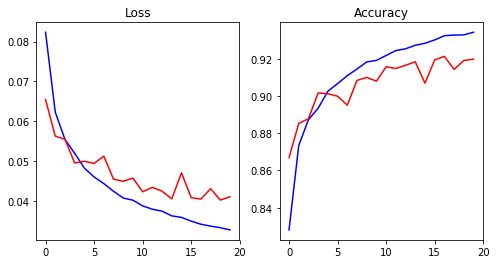

In [2]:
import keras
import keras.layers as layers
import keras.models as models
import keras.backend as K
from model import LogGaussMF


def train_hybrid():
    model = keras.Sequential([
        layers.Reshape((28,28,1), input_shape=(28,28)),
        layers.Conv2D(16, (3, 3), strides=(1,1), padding="same"),
        layers.BatchNormalization(scale=False),
        layers.Activation("relu"),
        layers.Dropout(rate=0.2),
        layers.Conv2D(32, (3, 3), strides=(2,2), padding="same"),
        layers.BatchNormalization(scale=False),
        layers.Activation("relu"),
        layers.Dropout(rate=0.2),
        layers.Conv2D(64, (3, 3), strides=(2,2), padding="same"),
        layers.BatchNormalization(scale=False),
        layers.Activation("relu"),
        layers.Dropout(rate=0.2),
        layers.Flatten(),
        LogGaussMF(10),
        layers.Lambda(lambda x: K.sum(x, axis=-1)),
        layers.Activation("softmax")
    ])
    
    model.compile(
        optimizer=keras.optimizers.adam(lr=0.001),
        loss="binary_crossentropy",
        metrics=[keras.metrics.categorical_accuracy])

    # train the model
    history = model.fit(
        x=train_x,
        y=train_y,
        batch_size=256,
        epochs=20,
        validation_data=(test_x, test_y),
        verbose=1,
        shuffle=True)
    
    # plot the loss and accuracy
    fig, axes = plt.subplots(1, 2, figsize=(8, 4), squeeze=True)
    axes[0].set_title("Loss")
    axes[0].plot(history.history["loss"], c="b")
    axes[0].plot(history.history["val_loss"], c="r")

    axes[1].set_title("Accuracy")
    axes[1].plot(history.history["categorical_accuracy"], c="b")
    axes[1].plot(history.history["val_categorical_accuracy"], c="r")

    return model


model = train_hybrid()

Use backpropagation to determine the maximizing inputs for each class. One hundred random images are optimized to maximize the selected output with the goal of obtaining clearer images. The success rate is the number of images that the model classifies as the target class.

success rate: 0.99
success rate: 1.0
success rate: 1.0
success rate: 0.98
success rate: 0.96
success rate: 1.0
success rate: 0.94
success rate: 0.92
success rate: 0.93
success rate: 1.0


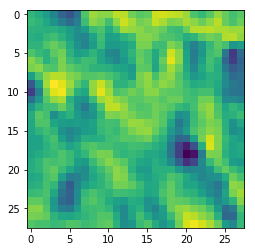

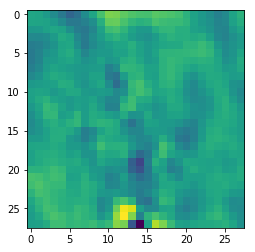

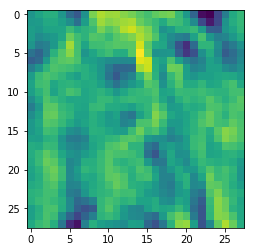

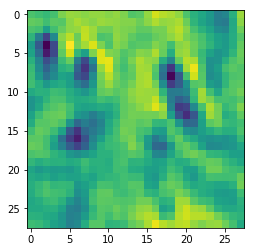

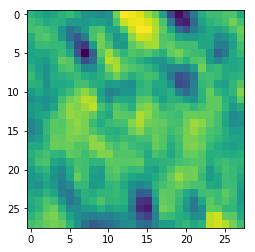

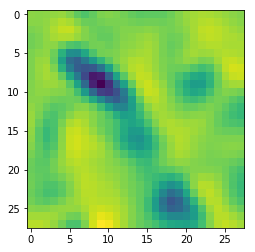

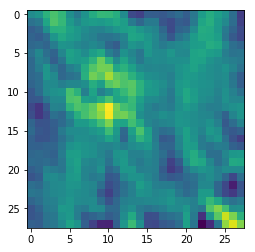

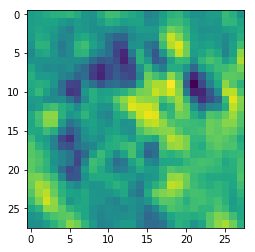

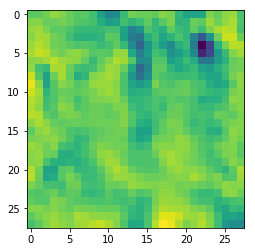

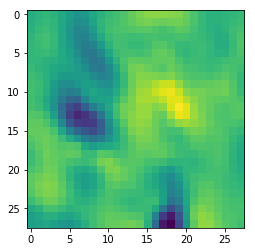

In [7]:
from scipy.ndimage.filters import gaussian_filter


def maximize_output(target_class):
    image = np.random.normal(0.5, 0.1, (100,28,28))
    mu, beta = model.layers[-3].get_weights()

    loss = K.sum(model.output[:,target_class])
    grads = K.gradients(loss, model.inputs)[0]
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-8)

    iterate = K.function(model.inputs, [loss, grads])

    for i in range(20):
        loss_val, grads_val = iterate([image])
        image += grads_val.reshape(-1,28,28)
        image = gaussian_filter(image, 0.5)

    plt.figure()
    plt.imshow(np.mean(image, axis=0))
    
    return np.mean(np.argmax(model.predict(image), axis=1) == target_class)
    

for i in range(10):
    print("success rate: {}". format(maximize_output(i)))

Unfortunately, the images do not resemble the training images, despite high success rates. Perhaps using guided backprop will yield better results.